# 1. Introduction to CUDA Programming Model and Toolkit



Welcome to the GPU short course exercises!

During this course we will introduce you to the syntax of CUDA programming in Python using the **CuPy** package. You will learn how to:
- implement and run a custom GPU CUDA C kernel,
- transfer data to and from GPU,
- how to verify correctness and performance of your implementation.

We will introduce you also to the CUDA Development Kit, in particular, you will learn how to use:
- CUDA debugger and profiler,
- GPU diagnostic tools.

In the first exercise, we will focus on optimizing a function that adds two vectors together.




**Input**:  

$a$, $b$: vectors of length $n$

**Output**: 

$c$: a vector of length $n$, $c_i = a_i + b_i$

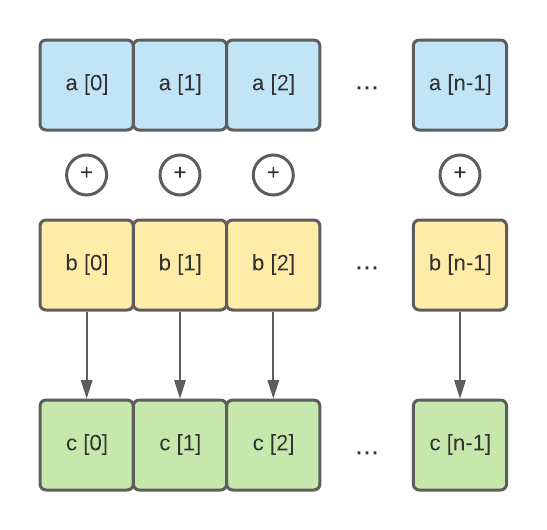

As part of the warm-up, let's implement the function that adds two vectors in Python:

In [1]:
import numpy as np

def add_vectors(a, b):
    # Make sure both vectors are the same length.
    assert len(a) == len(b)
    # Create the result array.
    n = len(a)
    c = [None]*n
    # Sum.
    for i in range(n):
        c[i] = a[i] + b[i]
    return c


# Let's now test it.
c = add_vectors([1, 2, 3, 4], 
                [4, 5, 6, 7])
# Verify the result.
np.testing.assert_equal(
    c,
    [5, 7, 9, 11]
)
print(c)

[5, 7, 9, 11]


Now, let's measure the time needed to sum two big-scale arrays:

In [2]:
a = np.random.rand(2**24).astype(np.float32) # ~ 1e7 elements
b = np.random.rand(2**24).astype(np.float32)

Using `add_vectors` function:

In [3]:
%%timeit -n 1
add_vectors(a, b)

6.47 s ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Using NumPy:

In [4]:
%%timeit -n 1
c = a + b

16.8 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Side note: `%%timeit` is an IPython's (which is used by Jupyter) built-in command that allows to time the execution of a Python command. A complete documentation for the command can be found [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit).

As you can see above, NumPy seems to be faster than the equivalent function implemented in Python, as the NumPy is optimized to perform operations on large arrays. Still, NumPy uses the CPU only to perform all computations. 

Will using the GPU in this case reduce the time it takes to add two vectors? Let's find out.

## 1.1. Heterogeneous programming with CUDA



Before we start implementing the CUDA kernel, let's discuss first how GPU and your computer (your GPU's **host**) can communicate.

Both the host computer and NVIDIA GPU are *separate* processing devices: each has its own **processing unit** and the **memory**. The GPU cores operate on data located in the GPU memory, and CPU cores operate on data located in the host's memory. Therefore, if one wants to perform calculations using the GPU, the input data must first be transferred from the host memory to the GPU memory, and the result data has to be transferred back to the host memory from the GPU.  

All the computations are done by some portion of GPU code called **GPU kernel**.  

The typical communication process between GPU and host is as follows:

1. Allocate a portion of the GPU memory.
2. Transfer data from the Host memory to the GPU Device memory (abbreviated as `HtoD` transfer).
3. Perform calculations on the data using the GPU kernel.
4. Transfer results from the GPU Device memory to the Host memory (abbreviated as `DtoH` transfer).
5. Release the allocated GPU memory.




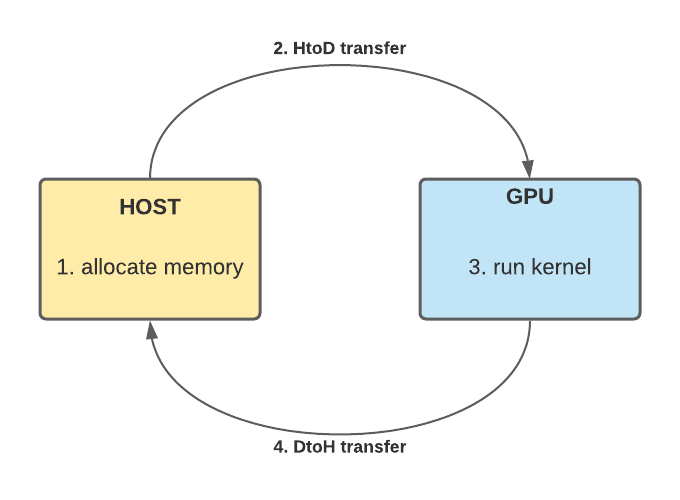

Data transfers and GPU kernels can be invoked by **host**, i.e. it is the host that initiates the transfer from / to the GPU device memory and the GPU calculations. Data transfers can be inititated using e.g. CUDA Application Programming Interface (API) or selected high-level libraries, like `numba` or `cupy` (which base on CUDA API).

We can distingush between two types of CUDA API calls:

- **synchronous** - the host waits for the GPU to finish the invoked operation,
- **asynchronous** - the host only invokes the GPU operation, it does not wait for its completion (returns immediately).

Data transfers in CUDA can be performed synchronously or asynchronously -- both sets of operations are available. 

CUDA kernel invocations are asynochronous: when we invoke a GPU kernel, the only job the CPU does is to enqueue the kernel to be executed on GPU, then the called function returns immediately.

The advantage of heterogenous programming with CUDA is that computing performed on the GPU can be done in parallel with the operations performed by CPU -- both CPU and GPU are separate processing devices that can work simultaneously thanks to the asynchronous functions available in CUDA. This allows us to e.g. delagate computationaly heavy tasks to the GPU, and perform all other work on Host at the same time.

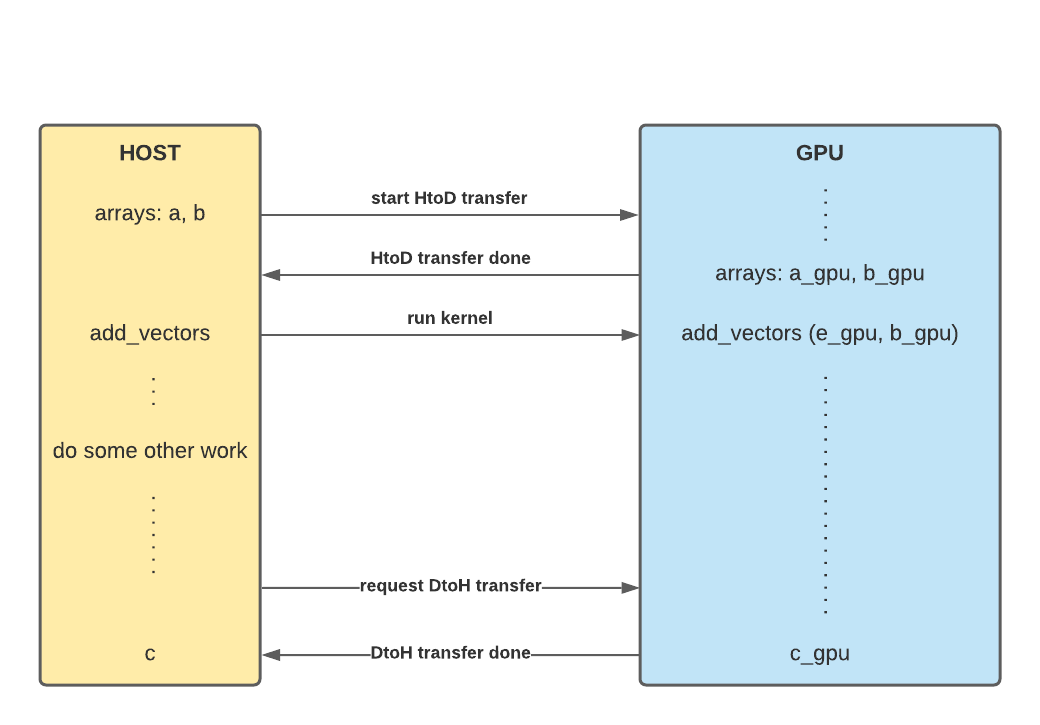

### 1.1.1 Data transfers in CuPy



The following functions for data transfers are available in CuPy:

- to allocate GPU memory, use: 
  - one of the [array creation routines](https://docs.cupy.dev/en/v9.3.0/reference/creation.html), e.g. [`cupy.empty`](https://docs.cupy.dev/en/v9.3.0/reference/generated/cupy.empty.html), [`cupy.empty_like`](https://docs.cupy.dev/en/v9.3.0/reference/generated/cupy.empty_like.html), [`cupy.array`](https://docs.cupy.dev/en/v9.3.0/reference/generated/cupy.array.html), 
- to transfer data from Host to GPU you can use e.g. [`cupy.ndarray.set`](https://docs.cupy.dev/en/v9.3.0/reference/generated/cupy.ndarray.html#cupy.ndarray.set),
- to transfer data from GPU to Host use [`cupy.ndarray.get`](https://docs.cupy.dev/en/v9.3.0/reference/generated/cupy.ndarray.html#cupy.ndarray.get). 

Also, the large number of functions documented [here](https://docs.cupy.dev/en/v9.3.0/reference/manipulation.html) allow for simultaneous memory allocation and data transfer, based on the provided `numpy.ndarray`. In later parts of this short-course, we will often use the [`cp.asarray`](https://docs.cupy.dev/en/v9.3.0/reference/generated/cupy.asarray.html) function, which is responsible for acquiring the appropriate amount of GPU memory and transferring HtoD.

Now, let's try implementing the communication process described in 1.1.

First, let's do all the necessary imports.

In [5]:
import cupy as cp
import numpy as np
import math

We will use `numpy` to manipulate Host memory, and `cupy` to manipulate GPU Device memory. 

Let's allocate some portion of data in the CPU and GPU memory.

In [6]:
array_host = np.arange(64, dtype=cp.float32)
array_host

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63.],
      dtype=float32)

In [7]:
array_gpu = cp.empty(shape=array_host.shape, dtype=array_host.dtype)

Now, let's transfer the `array` from Host to GPU memory.

In [8]:
array_gpu.set(array_host)
# Or do GPU memory allocation and data transfer in a single line:
# array_gpu = cp.asarray(array_host)

And move the GPU array back to Host memory.

In [9]:
result_array = array_gpu.get()
result_array

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63.],
      dtype=float32)

### 1.1.2 CUDA kernels

The CuPy package provides the possibility to write CUDA kernels directly in **CUDA C/C++**. If you are not familiar with C/C++, consider doing the Numba exercises first. Numba package allows to write GPU code using Python syntax directly.


For now, it will be enough to understand that:
- the code executed by each GPU core separately is called a *GPU kernel*,
- in CuPy, you can compile and run GPU kernel using using [`cupy.RawKernel`](https://docs.cupy.dev/en/v9.3.0/user_guide/kernel.html#raw-kernels) class.

The `RawKernel` class is not the only option to create a custom GPU kernel, the package also provides other, slightly simpler methods for creating user-defined GPU kernels (still, using a syntax similar to CUDA C/C++), which are described [here](https://docs.cupy.dev/en/v9.3.0/user_guide/kernel.html#). However, for this tutorial we will use `RawKernel` only, which gives the possibility to write GPU kernels using the standard CUDA syntax.
 

Let's create and run our first GPU kernel. We'll start with something very simple, i.e. create a CUDA kernel which simply does nothing (*NOP*). Open `1_1_first_kernel.cc` file and put the below code there:

```c
 extern "C"
__global__ void my_kernel() {
    // You can use C/C++ comments in the GPU source code.
}   
```


Now, now let's read the file in Python to string variable and compile it using the `cupy.RawKernel` class:

In [10]:
my_first_gpu_kernel_src = open("1_1_first_kernel.cc").read()
my_first_gpu_kernel = cp.RawKernel(code=my_first_gpu_kernel_src, name="my_kernel")
my_first_gpu_kernel.compile()

A few words of comment:
- GPU kernel, as we can see above, is written as a **C++ function**,
  - we used `__global__` keyword to indicate, that a given C++ function should be treated as a GPU kernel code than can be invoked by host,
  - you can use standard C/C++ syntax in the kernel's source code,
- *(CuPy specific)* in the example above, we used a Python string literal to store the kernel source, which is then passed to `RawKernel`'s constructor,
- *(CuPy specific)* the C++ function's name and `RawKernel`'s argument `name` should be the same. 
- *(CuPy specific)* it is recommended to declare CUDA kernels within `extern "C"` block - to make sure the C linkage is used and the kernel names are not mangled.


The following line launches the code to be executed by a single thread, in a single block, no input arguments.

In [11]:
my_first_gpu_kernel(grid=(1, ), block=(1, ), args=())

We will describe the CUDA kernel invocation parameters in more detail a bit later.

Combining it all together:

In [12]:
# Allocate Host memory.
array_host = np.arange(64, dtype=cp.float32)
# Allocate GPU memory.
array_gpu = cp.empty(shape=array_host.shape, dtype=array_host.dtype)
# Transfer from Host to GPU.
array_gpu.set(array_host)
# Run kernel
my_first_gpu_kernel(grid=(1, ), block=(1, ), args=())
# Move the array back to the Host.
result_array = array_gpu.get()
result_array

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63.],
      dtype=float32)

## 1.2. CUDA kernels and CUDA threads



Now that we know the syntax for writing and lanuching CUDA kernel code, we can proceed with implementing the `add_vectors` function for the GPU device. 

In this section:
- we will introduce a syntax for writing the CUDA GPU kernel,
- we will implement the `add_vectors` for function for NVIDIA GPU,
- we will analyze the time needed to perform the calculations on GPU.

The **GPU kernel** is a *device function* that is intended to be executed by a certain number of **CUDA threads**.

As mentioned before, CUDA kernel is a C++ function, represented by `cupy.RawKernel` object:



In [13]:
my_first_gpu_kernel

We can invoke a given kernel using the following syntax:
```
kernel_object(grid, block, arguments)
```
where:
- `grid` - dimensions of the grid of CUDA blocks,
- `block` - dimensions of the block of CUDA threads,
- `arguments` - CUDA kernel arguments.


So, to run kernel on a single thread, in a single block, for the `array_gpu` parameter:

In [14]:
my_first_gpu_kernel(grid=(1, ), block=(1, ), args=array_gpu)

If we want the kernel to be executed by two threads in a single block:

In [15]:
my_first_gpu_kernel(grid=(1, ), block=(2, ), args=array_gpu)

Both CUDA threads **will perform exactly the same function**, for the same `array_gpu`.

The use of GPU makes sense when the algorithm we implement decomposes well into many smaller subtasks - in this situation each task can be performed by a separate CUDA thread. Still, we need some way to assign each subtask to a separate CUDA thread.

In CUDA, each thread is assigned an identifier unique within a block, which can be also used as an identifier for the subtask for which it is responsible. To access the identifier, use `threadIdx.x` keyword. 

Let's take as an example the assignment `array_gpu = array_gpu + 1`, i.e. we want to add `1` to each element of the input `array_gpu`. 
We can split the task into `n` smaller subtasks: `array_gpu[i] = array_gpu[i] + 1`, `n` is the number of elements in the array. Now, we can use `threadIdx.x` to determine which elements the current thread should modify.

```cpp
extern "C"
__global__ void increment(float* data) {
    int i = threadIdx.x;
    data[i] = data[i] + 1;
}
```

Let's move the above code to the CUDA source file and run it (note: CUDA kernel will be compiled on the first run, usually we don't have to compile it manually):

In [16]:
increment_src = open("1_2_increment.cc").read()
increment = cp.RawKernel(code=increment_src, name="increment")

print(f"Before: {array_gpu}")

increment((1, ), (len(array_gpu), ), array_gpu)
result = array_gpu.get()

print(f"After: {result}")

Before: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63.]
After: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.]


#### 1.2.1. One-dimensional grid of CUDA threads

Now, let's extend the previous, basic example to the vector addition task.

Please note that the input vectors `a` and `b` are much larger than the `array_gpu`, so we cannot use a single block of threads with size ~ $10^7$. Blocks of this size are not supported by any of the NVIDIA GPUs (the actual limit on the block size is NVIDIA GPU-dependent, currently it should be around 1024). 

We have to split our task into multiple blocks of threads, that is to create a *grid* of blocks. 

How can we uniquely identify each CUDA thread in the *grid of blocks of threads*? Recall that the `threadIdx.x` is **a unique ID of a CUDA thread within a single block**. Each block also has **a unique ID within the entire grid**: `blockIdx.x`. Thus the pair:
```
(cuda.blockIdx.x, cuda.threadIdx.x) 
```
uniquely identifies every CUDA thread.



Let's decompose the vector element additions to *independent subtasks* in a similiar way as we did it in the `add_one` kernel. 

That is, each CUDA thread is responsible for computing a single element of the output array `c`:
```
c[i] = a[i] + b[i]
```

One more thing is necessary to obtain a unique position of the thread in the whole grid of threads: the size of a single block. 

For convenience CUDA provides the constant `blockDim.x`, which is equal to the number of threads in single block.

Now the unique position of the thread in the grid can be computed as:
```
blockIdx.x*blockDim.x + threadIdx.x
```

**Exercise**

1. Open `1_2_add_vectors.cc` file.
2. Fill in the missing lines of code, marked with the `// TODO: implement` comment.

In [17]:
add_vectors_src = open("1_2_add_vectors.cc").read()
add_vectors_gpu = cp.RawKernel(code=add_vectors_src, name="add_vectors")

Now, let's run the above kernel. Let's assume for a moment that we want the above CUDA kernel to be executed by 256 threads in parallel - i.e. one block will consists of 256 threads. To cover the entire input array, the kernel has to be executed by 

$\left\lceil \frac{n}{256} \right\rceil$ 

blocks of threads, where $n$ is the number of elements in input vectors.  

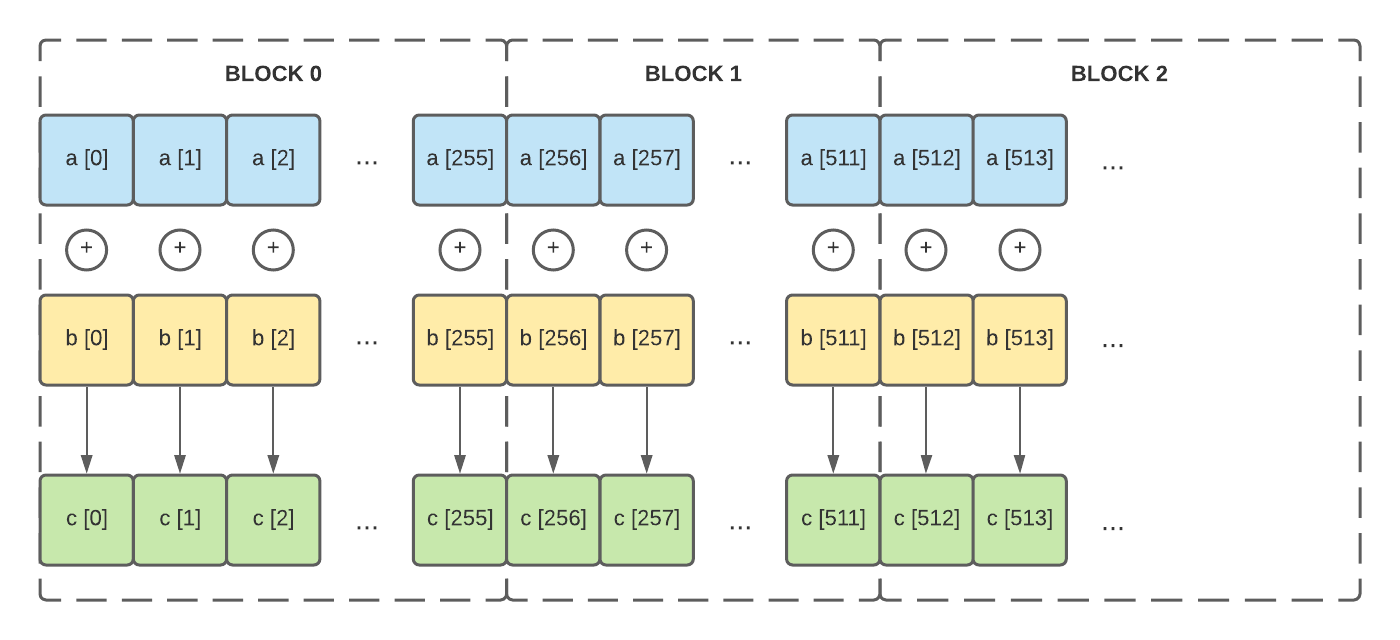

In [18]:
assert len(a) == len(b)
# Create output array in the GPU memory.
c_gpu = cp.empty(shape=a.shape, dtype=a.dtype)

# Transfer a and b to GPU.
a_gpu = cp.asarray(a)
b_gpu = cp.asarray(b)

# Determine grid and block sizes.
block_size = 256
grid_size = math.ceil(len(a)/block_size)

# Invoke the kernel.
add_vectors_gpu((grid_size, ), (block_size, ), (c_gpu, a_gpu, b_gpu, len(a_gpu)))
# Get the result.
c = c_gpu.get()

# Make sure we get the correct results (i.e. consistent with the results from NumPy).
np.testing.assert_equal(c, a+b)

Congratulations! You have solved your first GPU task, i.e. implementing the  `add_vectors` for NVIDIA GPU.

Now, let's measure the time needed to execute the `add_vectors_gpu` kernel.

In [19]:
%%timeit -n 100
add_vectors_gpu((grid_size, ), (block_size, ), (c_gpu, a_gpu, b_gpu, len(a_gpu)))
c = c_gpu.get()

13.1 ms ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As we can see, the execution time might be slightly shorter compared to its CPU counterpart (it will depend on the computer you use), but the difference is probably not significant. 

The above cell contains a data transfer from GPU to host.  The data transfer is a synchronous operation, i.e. it waits for all queued operations to be performed on GPU (including the kernel invocation), then performs the transfer. Thanks to that we are sure that the resulting array contains the complete calculation results.

However, transferring a large amount of data between GPU and Host can be time-consuming. To wait for the kernels to execute explicitly, without transferring the result data to host PC, run `cp.cuda.Stream.null.synchronize()`.

In [20]:
%%timeit -n 100
add_vectors_gpu((grid_size, ), (block_size, ), (c_gpu, a_gpu, b_gpu, len(a_gpu)))
cp.cuda.Stream.null.synchronize()

800 µs ± 564 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


CUDA streams will be covered in more detail later.

#### 1.2.2. Two-dimensional grid of CUDA threads

In the previous example, the grid of threads was defined in a single dimension, i.e. the variables `grid_size` and `block_size` were a single scalar value.

As mentioned previously, fields `blockIdx`, `blockDim` and `threadIdx` allow to determine the position of the current thread in the whole grid of threads executed by the CUDA device:
- `blockIdx` is the identifier of the currently executed block of threads in the grid,
- `blockDim` is the size of a single block of threads,
- `threadIdx` is the identifier of the currenty executed thread within a single block.


A grid of threads **can have one, two or three dimensions**, described by `(cuda.blockIdx.z, cuda.blockDim.y, cuda.blockDim.x)` tuple. 

Each thread in a block has the coordinates `(cuda.threadIdx.z, cuda.threadIdx.y, cuda.threadIdx.x)`. 

Each block in a grid has the coordinates `(cuda.blockIdx.z, cuda.blockIdx.y, cuda.blockIdx.x)`. 

The `x` coordinate changes the fastest: two adjacent threads in the same block differ in the value of the `x` coordinate by 1.

Grid and thread dimensions can be specified via the `grid_size` and `thread_size` parameters: a single scalar value means that a 1-D grid will be used, a pair of values imposes a 2-D grid, three values sets 3-D grid. 




This time, we will implement a function which adds two **matrices** and we will use a 2-D grid of threads for this purpose.

Let's use a 2D grid and block thread organization to implement a kernel that adds two matrices. We will start first with a baseline function for CPU.

In [21]:
import itertools
import numpy as np 


def add_matrices(a, b):
    a = np.array(a)
    b = np.array(b)
    assert a.shape == b.shape
    
    height, width = a.shape
    result = np.zeros(a.shape, dtype=a.dtype)
    
    for i, j in itertools.product(range(height), range(width)):
        result[i, j] = a[i, j] + b[i, j]
    return result

c = add_matrices(
    # a = 
    [[ 1,  2,  3,  4], 
     [ 4,  5,  6,  7]],
    # b =  
    [[-1, -2, -3, -4],
     [ 1,  1,  1,  1]])

np.testing.assert_equal(
    c, np.array([[0, 0, 0, 0],
                 [5, 6, 7, 8]]))

In [22]:
a = np.random.rand(2**12, 2**12).astype(np.float32) # ~ 1e7 elements
b = np.random.rand(2**12, 2**12).astype(np.float32)

c = add_matrices(a, b)
np.testing.assert_equal(c, a + b)

In [23]:
%%timeit -n 2
add_matrices(a, b)

8.59 s ± 51.5 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


Similarly to the `add_vectors_gpu` implementation,  the `add_matrices_gpu` kernel will compute a single matrix element. This time, we will use the `y` coordinate to address matrix elements in the second dimension.

**Exercise**

1. Open `1_2_add_matrices.cc` file.
2. Fill in the missing lines of code, marked with the `// TODO` comment.

In [24]:
add_matrices_src = open("1_2_add_matrices.cc").read()
add_matrices_gpu_kernel = cp.RawKernel(code=add_matrices_src, name="add_matrices")

Now, we must also pass the second dimension of the grid to the GPU kernel invocation parameters, as the implementation of the kernel assumes a 2-D grid layout. The parameters `grid_size` and `block_size` should be now pairs of integer values.

Let's wrap GPU kernel invocation code into a `add_matrices_gpu` Python function:

In [25]:
def add_matrices_gpu(a, b):
    assert a.shape == b.shape
    # Move a and b to GPU.
    a_gpu = cp.asarray(a)
    b_gpu = cp.asarray(b)

    # Create output array in the GPU memory.
    c_gpu = cp.empty(shape=a.shape, dtype=a.dtype)

    # Determine CUDA kernel grid dimensions.
    height, width = a.shape
    block_size = (16, 16)
    grid_size = (math.ceil(width/block_size[0]), math.ceil(height/block_size[1]))
    
    # Invoke the kernel.
    add_matrices_gpu_kernel(grid_size, block_size, (c_gpu, a_gpu, b_gpu, height, width))
    # Wait until all computation is done and transfer result data from GPU to host.
    c = c_gpu.get()
    return c

Let's test the implementation first:

In [26]:
# Small
c = add_matrices_gpu(
    a=np.array([[ 1,  2,  3,  4], 
                [ 4,  5,  6,  7]]).astype(np.float32),
    b=np.array([[-1, -2, -3, -4],
                [ 1,  1,  1,  1]]).astype(np.float32)
)
np.testing.assert_equal(
    c, np.array([[0, 0, 0, 0],
                 [5, 6, 7, 8]]))

# Large
c = add_matrices_gpu(a, b)
np.testing.assert_equal(c, a+b)

Compare CPU and GPU processing time:

In [27]:
%%timeit
add_matrices_gpu(a, b)

29.8 ms ± 33.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We'll leave the implementation of adding two 3D arrays for you to try as homework.

## 1.3. CUDA Toolkit and CuPy package

NVIDIA provides several tools in its Toolkit that help in the implementation and testing of the GPU code. In this exercise we will show you how to:
- check the parameters of your hardware, determine how to programatically check how many GPUs and how much memory are available, and so on,
- debug and memcheck you Python CUDA kernels,
- profile CUDA code execution time.

We will also introduce you to more details of CuPy Python package, which we will be using during the entire course.

### 1.3.1. CUDA device diagnostics

The most basic diagnostic tool for GPU cards is `nvidia-smi`, which displays the current status of all GPU cards available.

(NOTE: the `nvidia-smi` tool is not available for Nvidia Jetson processors. For SoC chips, please use built-in `tegrastats` or install [`jtop`](https://pypi.org/project/jetson-stats/)).

In [28]:
! nvidia-smi

Mon Aug 23 01:59:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:05:00.0 Off |                  N/A |
| 25%   65C    P2    82W / 250W |    501MiB / 12211MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:06:00.0 Off |                  N/A |
| 25%   

`nvidia-smi` outputs information about:
- the installed NVIDIA driver and CUDA Toolkit,
- for each available GPU:
  - temperature, memory usage and GPU utilization,
  - processes that are currently running on that GPU.

 

`nvidia-smi` is a command line tool, so use it in your shell to quickly check the state of your GPU. 

CUDA SDK also provides a programatic way to access the device description in your application run-time, e.g. to check if we are not exceeding available GPU global memory.

The CUDA device description is called in SDK *device properties*. 

To get the device properties, we will use `cupy` package, which exposes CUDA SDK interface in Python in a convenient way.

Let's check first how many GPU cards do we have:



In [29]:
import cupy as cp
cp.cuda.runtime.getDeviceCount()

1

Now, let's check:

- the device name and its compute capability,
- the GPU clock frequency,
- how much global, shared and constant memory our GPU card has.

In [30]:
device_props = cp.cuda.runtime.getDeviceProperties(0)

print(f"Device: {device_props['name']} (cc {device_props['major']}.{device_props['minor']})")
print(f"GPU clock frequency: {device_props['clockRate']/1e3} MHz")
print("Available memory: ")
print(f"- global memory: {device_props['totalGlobalMem']/2**20} MiB")
print(f"- shared memory per thread block: {device_props['sharedMemPerBlock']} B")
print(f"- constant memory: {device_props['totalConstMem']} B")

Device: b'GeForce GTX TITAN X' (cc 5.2)
GPU clock frequency: 1076.0 MHz
Available memory: 
- global memory: 12211.5 MiB
- shared memory per thread block: 49152 B
- constant memory: 65536 B


The complete list of device properties is available [here](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__DEVICE.html#group__CUDART__DEVICE_1g1bf9d625a931d657e08db2b4391170f0).


### 1.3.2. CuPy

- CuPy is an open-source GPU-accelerated library for scientific computing.
- The library is NumPy-compatible: it implements most of the features available in NumPy and SciPy packages, making it easy to implement portable code between CPU and GPU.
- In addition to high-level array operations:
  - allows you to run your own kernel implemented in CUDA C / C ++, 
  - provides Python with most of the functions available in the NVIDIA CUDA API for C/C++ (e.g. to access device properties).

CuPy documentation is available here: https://docs.cupy.dev/en/v9.3.0/index.html

#### 1.3.2.1. Mixing custom CUDA kernels with array operations

It is possible to mix RawKernel invocation with high-level array operations available in CuPy, i.e. arguments and results of the GPU kernels can be passed to/from the CuPy functions. 

For example, let's compute $2(x^2 + y^2)$, where $x$ and $y$ are vectors:

In [31]:
x = cp.array([1, 2, 3, 4], dtype=cp.float32)
y = cp.array([2, 3, 4, 5], dtype=cp.float32)

x_gpu = cp.asarray(x)
y_gpu = cp.asarray(y)
result = cp.empty_like(x)

# Raise to power using CuPy high-level functions.
x_gpu = x_gpu**2
y_gpu = y_gpu**2

add_vectors_gpu(grid=(1,), block=(len(x),), args=(result, x_gpu, y_gpu, len(x_gpu)))

result = 2*result

print(result)

[10. 26. 50. 82.]


#### 1.3.2.2. RawKernel lazy compilation

It's important to stress here that CuPy compiles CUDA kernel *lazily*, which means it compiles a given function to machine code **on the first function call**. Compilation is performed only once - the first time a given function is run. After that, a cached version of machine code is used.

Let's see how long it will take to execute the brand new kernel the first time:

In [32]:
decrement_src = open("1_3_decrement.cc").read()
decrement = cp.RawKernel(code=decrement_src, name="decrement")

In [33]:
%time decrement(grid=(1,), block=(5,), args=(cp.arange(5).astype(cp.float32), ))

CPU times: user 474 ms, sys: 95 µs, total: 474 ms
Wall time: 474 ms


The second kernel execution takes:

In [34]:
%time decrement(grid=(1,), block=(5,), args=(cp.arange(5).astype(cp.float32), ))

CPU times: user 910 µs, sys: 0 ns, total: 910 µs
Wall time: 729 µs


### 1.3.3 Memcheck and debugger

#### 1.3.3.1 Memcheck

CUDA-MEMCHECK is a tool available in CUDA SDK, which gives the possibility to check if the CUDA application makes any of the following errors:
- misaligned and out-of-bounds memory access errors,
- shared memory data races,
- unintialized accesses to global memory. 

Let's debug the below Python script in order to detect any memory issues it may cause. We will save the below Jupyter Cell to Python script, and run `CUDA-MEMCHECK` for the Python interpreter which executes that script.

In [35]:
%%writefile 1_3_memcheck.py

import numpy as np
import cupy as cp
import math
import time

# CUDA kernel
add_vectors_invalid_src = open("1_3_add_vectors_invalid.cc").read()

add_vectors_invalid = cp.RawKernel(
    code=add_vectors_invalid_src, 
    name="add_vectors_invalid",
    options=("-G", ) # Compile with debug information.
)

# GPU memory allocation and initialization.
a = cp.arange(255, dtype=cp.float32)
b = cp.arange(255, dtype=cp.float32)
c = cp.empty(shape=a.shape, dtype=a.dtype)

# Invoke kernel.
add_vectors_invalid(grid=(1,), block=(1,), args=(c, a, b))
cp.cuda.Stream.null.synchronize()

Writing 1_3_memcheck.py


The only thing the above cell does is save the Python code to the `1_3_3_memcheck.py` script in the current directory (you can check it using `! pwd` command). Now, we can run `cuda-memcheck` along with the Python interpreter in order to see if there any issues with the script.

In [36]:
! cuda-memcheck --show-backtrace no python 1_3_memcheck.py

========= CUDA-MEMCHECK
========= Invalid __global__ write of size 4
=========     at 0x00000370 in /tmp/tmpuvvyzquo/31641231bc164e30e7777d95d71776d9_2.cubin.cu:6:add_vectors_invalid
=========     by thread (0,0,0) in block (0,0,0)
=========     Address 0x00000000 is out of bounds
========= Program hit cudaErrorLaunchFailure (error 719) due to "unspecified launch failure" on CUDA API call to cudaStreamSynchronize.
========= Program hit cudaErrorLaunchFailure (error 719) due to "unspecified launch failure" on CUDA API call to cudaGetLastError.
Traceback (most recent call last):
  File "1_3_memcheck.py", line 23, in <module>
    cp.cuda.Stream.null.synchronize()
  File "cupy/cuda/stream.pyx", line 221, in cupy.cuda.stream.BaseStream.synchronize
  File "cupy_backends/cuda/api/runtime.pyx", line 894, in cupy_backends.cuda.api.runtime.streamSynchronize
  File "cupy_backends/cuda/api/runtime.pyx", line 273, in cupy_backends.cuda.api.runtime.check_status
cupy_backends.cuda.api.runtime.CUDARun

As we can see, CUDA-MEMCHECK detected that the `add_vectors_invalid` kernel was not properly executed because it tried to access memory at address `0x00000000`.

#### 1.3.3.2 CUDA Debugger

CUDA SDK toolkit includes debuggers that can be run on GPU kernel code in case it's necessary to trace the cause of an issue. A list of CUDA debuggers that can be run on C++ CUDA kernel code is available here: [Linux](https://docs.nvidia.com/cuda/cuda-gdb/index.html), [Windows](https://docs.nvidia.com/nsight-visual-studio-edition/cuda-debugger/).

In this notebook we will introduce you with the basics of using `cuda-gdb` debugger, available for Linux & Mac OS. 

Before starting CUDA C debugger, we will set the following environment variables first:
- `export CUPY_CACHE_SAVE_CUDA_SOURCE=1`
- `export CUPY_CUDA_COMPILE_WITH_DEBUG=1`

Setting `CUPY_CACHE_SAVE_CUDA_SOURCE` to `1` instructs CuPy to save CUDA C source file along with the compiled binary in the cache directory (usually `${HOME}/.cupy/kernel_cache` directory).

Setting `CUPY_CUDA_COMPILE_WITH_DEBUG` to `1` instructs CuPy to compile CUDA code with debug information.



The cell below saves the complete Python script, including the `add_vectors` GPU kernel, to the file `1_3_add_vectors.py`:

In [37]:
%%writefile 1_3_add_vectors.py

import math
import numpy as np
import cupy as cp

add_vectors_src = open("1_2_add_vectors.cc").read()
add_vectors_gpu = cp.RawKernel(code=add_vectors_src, name="add_vectors")

n = 4

a = np.arange(n).astype(np.float32)+1
b = np.arange(n).astype(np.float32)+4
y = cp.empty(shape=(n, ), dtype=cp.float32)

add_vectors_gpu(grid=(1, ), block=(n, ), 
                   args=(y, cp.asarray(a), cp.asarray(b), n))
result = y.get()
np.testing.assert_equal(result, [5, 7, 9, 11])

Writing 1_3_add_vectors.py


Now, let's open terminal and run the following command:

```
cuda-gdb --args python 1_3_add_vectors.py
```

You should see an output similiar to the following:

```
NVIDIA (R) CUDA Debugger
11.0 release
Portions Copyright (C) 2007-2020 NVIDIA Corporation
GNU gdb (GDB) 8.3.1
Copyright (C) 2019 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.
Type "show copying" and "show warranty" for details.
This GDB was configured as "x86_64-linux-gnu".
Type "show configuration" for configuration details.
For bug reporting instructions, please see:
<http://www.gnu.org/software/gdb/bugs/>.
Find the GDB manual and other documentation resources online at:
    <http://www.gnu.org/software/gdb/documentation/>.

For help, type "help".
Type "apropos word" to search for commands related to "word"...
Reading symbols from python...
(cuda-gdb)
```

Let's set the breakpoint (the line of code where the debugger should stop kernel execution) to the beginning of the `add_vectors` function, thread with idx = 3. Run in a `(cuda-gdb)` prompt the following command:
```
(cuda-gdb) break add_vectors if threadIdx.x == 3
```

Press `y` if you see the following question:
```
Function "add_vectors" not defined.
Make breakpoint pending on future shared library load? (y or [n])
```

Press `y`

Now let's run our Python script. Run the following command:
```
(cuda-gdb) run
```

You should see text on the screen ending with something similar to the text below:

```
[Switching focus to CUDA kernel 0, grid 1, block (0,0,0), thread (3,0,0), device 0, sm 0, warp 0, lane 3]

Thread 1 "python" hit Breakpoint 1, add_vectors<<<(1,1,1),(4,1,1)>>> (c=0x7fff40800000, a=0x7fff40800200, b=0x7fff40800400, n=4) at /tmp/tmpgnunez8r/1d312fd8bf600b37efca2d31212f0d9d_2.cubin.cu:5
5	/tmp/tmpgnunez8r/1d312fd8bf600b37efca2d31212f0d9d_2.cubin.cu: No such file or directory.
```

CuPy had created a temporary file in the tmp folder during compilation, then moved this file to the directory with cached kernels (`${HOME}/.cupy/kernel_cache`), and now we are getting an information the the source file located in the `/tmp` directory is missing. Let's instruct `cuda-gdb` to use the source files located in the `kernel_cache` directory:
```
set substitute-path /tmp/tmpgnunez8r/1d312fd8bf600b37efca2d31212f0d9d_2.cubin.cu /home/pjarosik/.cupy/kernel_cache/1d312fd8bf600b37efca2d31212f0d9d_2.cubin.cu` 
```

**NOTE**: remember to update the path to the kernel cache (`/home/pjarosik/.../`) and to the `cubin.cu` file name (just use the file name indicated in the above error message).

Now, when you run command `step`, you should see the next line being executed by `cuda-gdb`:
```
(cuda-gdb) step
8	        if(i >= n) {
```
You can print a value of a variable you are interested in:
```
(cuda-gdb) print i
$1 = 3
```
To resume program execution, run:
```
(cuda-gdb) continue
```

To exit `cuda-gdb`:

```
(cuda-gdb) quit
```


### 1.3.4. Profiling GPU code


Sometimes, to better understand and optimize performance of a GPU appplication it is necessary to perform a dynamic program analysis and to mesaure specific metrics, for example the execution time and memory requirements of a particular CUDA kernel. The utility that performs such analysis is usually called a *code profiler*.

NVIDIA provides a number of tools that enable code profiling. Some of them allow you to perform inspections from the command line, while others provide a graphical user interface that clearly presents various code metrics. In this excersie we will introduce the tools available in the CUDA ecosystem.

**NOTE**: NVIDIA is currently migrating to a new profiling toolkit called *NVIDIA Nsight Systems* and NVIDIA Nsight Compute system. We will extend this exercise with examples of their use in the future.

#### 1.3.4.1. NVPROF

`nvprof` is a CUDA SDK tool that allows to acquire profiling data directly from the command line. Documentation for the tool is available [here](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview). 

We will use `nvprof` for the rest of this course.

Let's try profiling our `add_vectors_gpu` code first.

In [38]:
%%writefile 1_3_nvprof_add_vectors.py

import math
import numpy as np
import cupy as cp

add_vectors_src = open("1_2_add_vectors.cc").read()
add_vectors_gpu = cp.RawKernel(code=add_vectors_src, name="add_vectors")

n = 4

a = np.arange(n).astype(np.float32)+1
b = np.arange(n).astype(np.float32)+4
y = cp.empty(shape=(n, ), dtype=cp.float32)

add_vectors_gpu(grid=(1, ), block=(n, ), 
                   args=(y, cp.asarray(a), cp.asarray(b), n))
result = y.get()
np.testing.assert_equal(result, [5, 7, 9, 11])

Writing 1_3_nvprof_add_vectors.py


The usage is the following:
```
nvprof [options] [application] [application-arguments]
```

For example, to run the above Python script:

In [39]:
! nvprof python 1_3_nvprof_add_vectors.py

==25071== NVPROF is profiling process 25071, command: python 1_3_nvprof_add_vectors.py
==25071== Profiling application: python 1_3_nvprof_add_vectors.py
==25071== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   38.99%  2.7200us         2  1.3600us  1.0240us  1.6960us  [CUDA memcpy HtoD]
                   37.61%  2.6240us         1  2.6240us  2.6240us  2.6240us  add_vectors
                   23.39%  1.6320us         1  1.6320us  1.6320us  1.6320us  [CUDA memcpy DtoH]
      API calls:   99.38%  361.12ms         3  120.37ms  8.0300us  361.10ms  cudaMalloc
                    0.23%  843.33us         1  843.33us  843.33us  843.33us  cuDeviceTotalMem
                    0.13%  469.64us       101  4.6490us     220ns  205.16us  cuDeviceGetAttribute
                    0.11%  382.95us         1  382.95us  382.95us  382.95us  cudaHostAlloc
                    0.05%  178.28us         1  178.28us  178.28us  178.28us  cuDevice

By default, `nvprof` outputs all GPU and API calls activity. We are primarily interested in CUDA GPU tracing -- we can turn off API calls by using `--trace gpu` option.

In [40]:
! nvprof --trace gpu python 1_3_nvprof_add_vectors.py

==25125== NVPROF is profiling process 25125, command: python 1_3_nvprof_add_vectors.py
==25125== Profiling application: python 1_3_nvprof_add_vectors.py
==25125== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   39.53%  2.7200us         2  1.3600us  1.0240us  1.6960us  [CUDA memcpy HtoD]
                   37.21%  2.5600us         1  2.5600us  2.5600us  2.5600us  add_vectors
                   23.26%  1.6000us         1  1.6000us  1.6000us  1.6000us  [CUDA memcpy DtoH]
No API activities were profiled.


CUDA GPU activities include:
- CUDA kernels activities,
- GPU to Host memory transfers (`DtoH`), host to GPU memory transfers (`HtoD`).

Let's add one more kernel to the above code:

In [41]:
%%writefile 1_3_nvprof_increment_add_vectors.py

import math
import numpy as np
import cupy as cp

increment_src = open("1_2_increment.cc").read()
increment_gpu = cp.RawKernel(code=increment_src, name="increment")

add_vectors_src = open("1_2_add_vectors.cc").read()
add_vectors_gpu = cp.RawKernel(code=add_vectors_src, name="add_vectors")

n = 2**24
block = 256
grid = math.ceil(n/block)
block = (block, )
grid =  (grid, )

a = np.random.rand(n).astype(np.float32)
a = cp.asarray(a)
b = np.random.rand(n).astype(np.float32)
b = cp.asarray(b)
y = cp.empty(shape=n, dtype=cp.float32)

increment_gpu(grid, block, args=(a, n))
add_vectors_gpu(grid, block, args=(y, a, b, n))
result = y.get()

Overwriting 1_3_nvprof_increment_add_vectors.py


In [42]:
! nvprof --trace gpu python 1_3_nvprof_increment_add_vectors.py

==25179== NVPROF is profiling process 25179, command: python 1_3_nvprof_increment_add_vectors.py
==25179== Profiling application: python 1_3_nvprof_increment_add_vectors.py
==25179== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   44.78%  12.176ms         1  12.176ms  12.176ms  12.176ms  [CUDA memcpy DtoH]
                   39.71%  10.797ms         2  5.3984ms  5.3901ms  5.4066ms  [CUDA memcpy HtoD]
                   12.61%  3.4290ms         1  3.4290ms  3.4290ms  3.4290ms  increment
                    2.89%  786.33us         1  786.33us  786.33us  786.33us  add_vectors
No API activities were profiled.


In the above case, `nvprof` should display the execution times for both kernels.

#### 1.3.4.2. NVIDIA Visual Profiler

NVIDIA Visual Profiler (NVVP) allows to visualize profiling results in a transparent manner. In addition to presenting kernel execution time, NVVP also allows to analyze the moments where each particular kernel starts and ends.

Let's export the profiling results to a file that can be loaded by NVVP. We can `nvprof` for this purpose, just use `--export-profile` parameter.

In [43]:
! nvprof --trace gpu --export-profile nvvp_example.nvvp -f python 1_3_nvprof_increment_add_vectors.py

==25233== NVPROF is profiling process 25233, command: python 1_3_nvprof_increment_add_vectors.py
==25233== Generated result file: /home/pjarosik/src/us4useu/ius-2021-gpu-short-course/exercises/cupy/1_CUDA_programming_model/solutions/nvvp_example.nvvp


Next, let's load the profiling results into NVVP:
1. Open NVVP.
2. Press: File -> Open and choose the exported file.

You should now see an image similar to the one below. The graph presents the moments of execution for each individual GPU activity over time. CUDA kernel launches are placed on the `Compute` lane (in the order in which they are executed: `increment` first, then `add_vectors`) CUDA memory transfers are on the `MemCpy` lanes (variable `a`, then variable `b`, both `HtoD`, then `result`, `DtoH`). 

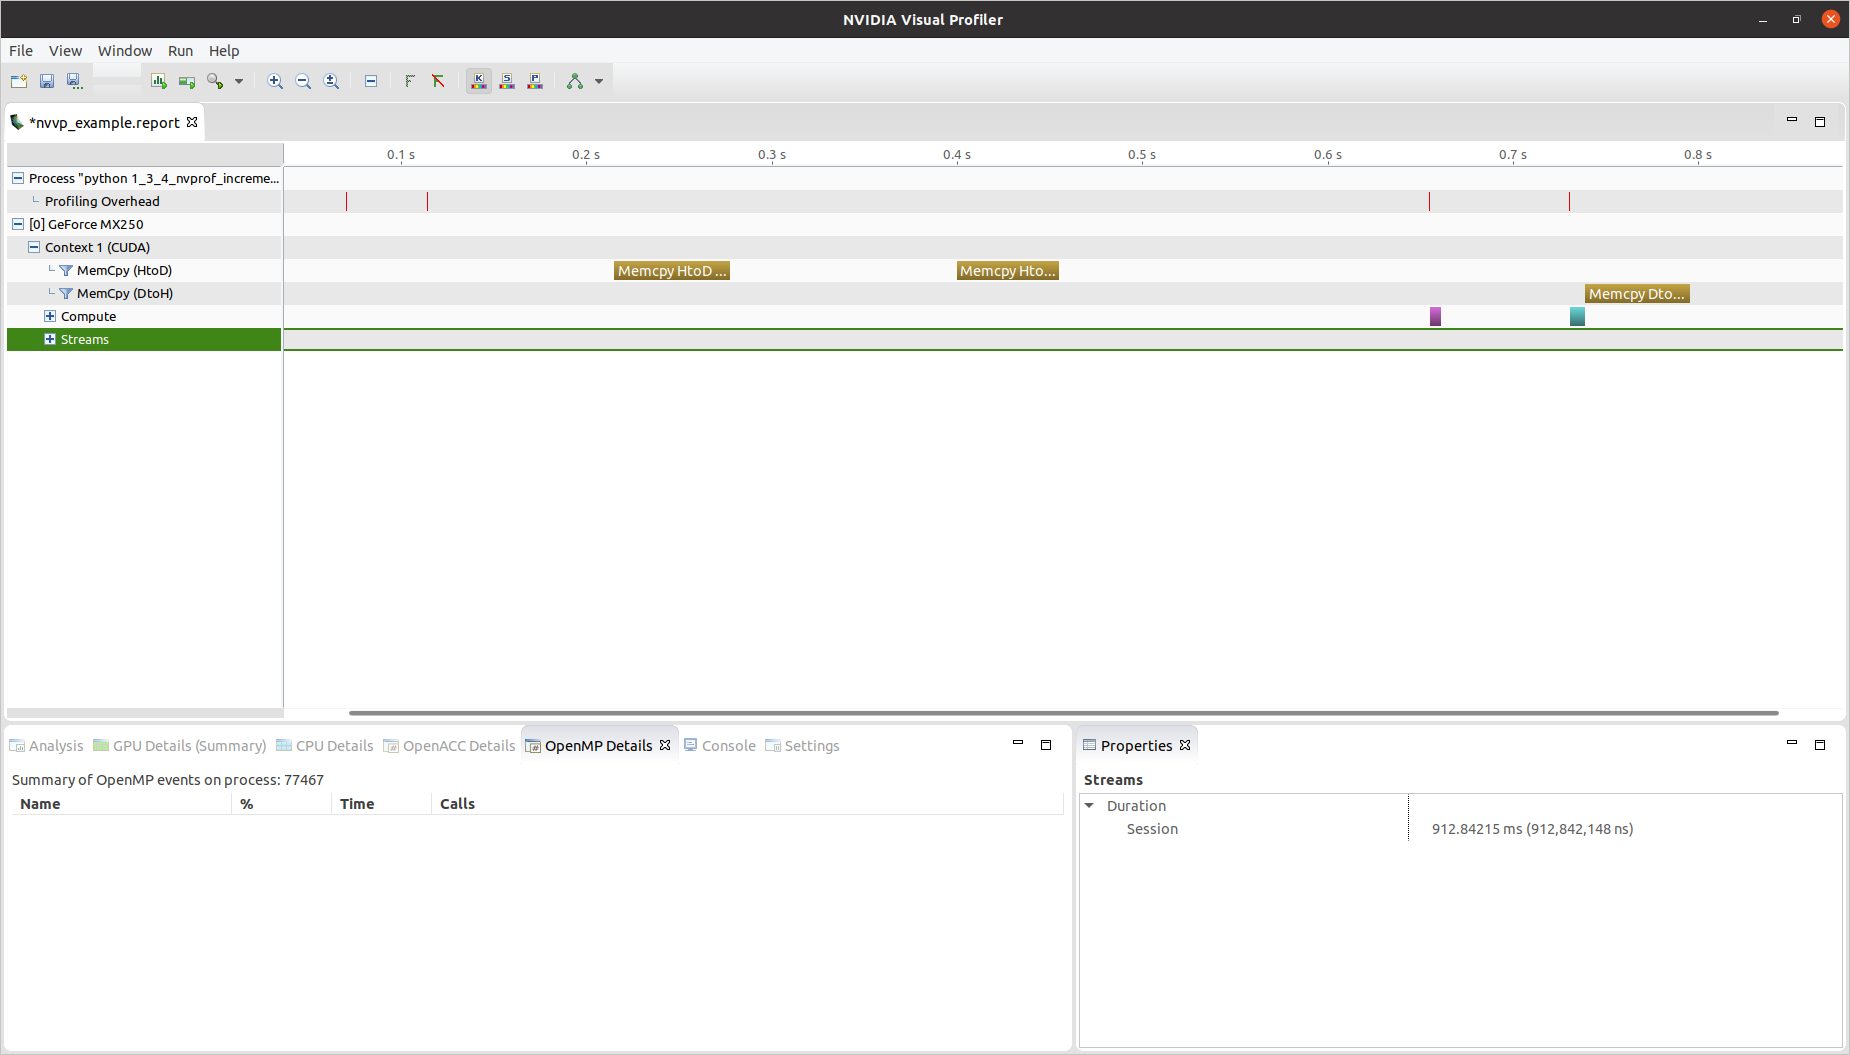

#### 1.3.4.3. Nsight Compute and Systems

NVIDIA is currently migrating to a new profiling toolkit called NVIDIA [Nsight Systems](https://docs.nvidia.com/nsight-systems/UserGuide/index.html) and [Nsight Compute](https://docs.nvidia.com/nsight-compute/index.html). 

As we have mentioned previously, in the current version of the GPU short-course notebooks we rather prefer using the old tools `nvprof` and NVVP instead of Nsight Systems and Nsight Compute. In future we will probably suplement notebooks with examples how to use the new tools.

If your GPU card no longer supports `nvprof` functionality, you can use a similar command line profiling tool `nsys` (part of Nsight Systems) in the following way: 

In [44]:
! nsys profile --stats=true --trace cuda python 1_3_nvprof_increment_add_vectors.py

Processing events...
Saving temporary "/tmp/nsys-report-ab39-67e7-23fc-9ad6.qdstrm" file to disk...
Creating final output files...

Processing [==============================================================100%]
Saved report file to "/tmp/nsys-report-ab39-67e7-23fc-9ad6.qdrep"
Exporting 451 events: [===================================================100%]

Exported successfully to
/tmp/nsys-report-ab39-67e7-23fc-9ad6.sqlite

Generating CUDA API Statistics...
CUDA API Statistics (nanoseconds)

Time(%)      Total Time       Calls         Average         Minimum         Maximum  Name                                                                            
-------  --------------  ----------  --------------  --------------  --------------  --------------------------------------------------------------------------------
   91.3       331858512           3     110619504.0          285459       327591542  cudaMalloc                                                                      
    

# References

- Matrix multiplication example https://numba.readthedocs.io/en/0.52.0/cuda/examples.html#matrix-multiplication
- CUDA Toolkit documentation: device memory management (CUDA C++): https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#device-memory